In [1]:
# Set up environment variables
# IMPORTANT: Set these in your .env file or system environment variables before running
# Copy .env.example to .env and fill in your actual API keys
%env OPENROUTER_API_KEY=your_openrouter_api_key_here


env: OPENROUTER_API_KEY=your_openrouter_api_key_here


In [2]:
from datasets import load_dataset

benchmark = load_dataset("cais/mmlu", "all")

print(benchmark)

DatasetDict({
    test: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 14042
    })
    validation: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 1531
    })
    dev: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 285
    })
    auxiliary_train: Dataset({
        features: ['question', 'subject', 'choices', 'answer'],
        num_rows: 99842
    })
})


In [28]:
benchmark['test'][0]

{'question': 'Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.',
 'subject': 'abstract_algebra',
 'choices': ['0', '4', '2', '6'],
 'answer': 1}

In [52]:
raw_benchmark = load_dataset("openlifescienceai/medmcqa")

def convert_medmcqa_example(example):
    return {
        "question": example["question"],
        "subject": example.get("subject_name", ""),
        "choices": [example["opa"], example["opb"], example["opc"], example["opd"]],
        "answer": example["cop"]
    }

benchmark = {}
for split in raw_benchmark:
    benchmark[split] = raw_benchmark[split].map(convert_medmcqa_example)

benchmark['train'][0]

{'id': 'e9ad821a-c438-4965-9f77-760819dfa155',
 'question': 'Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma',
 'opa': 'Hyperplasia',
 'opb': 'Hyperophy',
 'opc': 'Atrophy',
 'opd': 'Dyplasia',
 'cop': 2,
 'choice_type': 'single',
 'exp': 'Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950',
 'subject_name': 'Anatomy',
 'topic_name': 'Urinary tract',
 'subject': 'Anatomy',
 'choices': ['Hyperplasia', 'Hyperophy', 'Atrophy', 'Dyplasia'],
 'answer': 2}

In [53]:
benchmark

{'train': Dataset({
     features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'subject', 'choices', 'answer'],
     num_rows: 182822
 }),
 'test': Dataset({
     features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'subject', 'choices', 'answer'],
     num_rows: 6150
 }),
 'validation': Dataset({
     features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name', 'subject', 'choices', 'answer'],
     num_rows: 4183
 })}

In [54]:
from os import getenv
from langchain_openai import ChatOpenAI

# Initialize the language model
llm = ChatOpenAI(
  model="openai/gpt-4.1", 
  temperature=0,
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY")
  )

In [55]:
from pydantic import BaseModel, Field

class MMLUResponseCOT(BaseModel):
    reasoning: str = Field(description="The reasoning process that led to the answer")
    answer: str = Field(description="The answer to the question as a single letter (e.g., A, B, C, D)")
    
class MMLUResponseNoCOT(BaseModel):
    answer: str = Field(description="The answer to the question as a single letter (e.g., A, B, C, D)")
    


In [56]:
from langchain_core.prompts import ChatPromptTemplate

simple_qa_prompt = ChatPromptTemplate.from_messages([
    ("human", """\
{question}

{options}

{instructions}""")
])

def get_qa_response(llm, prompt, structured_output=False):
    if structured_output:
        return llm.with_structured_output(structured_output).invoke(prompt)
    else:
        return llm.invoke(prompt)
    

In [57]:
benchmark["validation"][0]

{'id': '45258d3d-b974-44dd-a161-c3fccbdadd88',
 'question': 'Which of the following is not true for myelinated nerve fibers:',
 'opa': 'Impulse through myelinated fibers is slower than non-myelinated fibers',
 'opb': 'Membrane currents are generated at nodes of Ranvier',
 'opc': 'Saltatory conduction of impulses is seen',
 'opd': 'Local anesthesia is effective only when the nerve is not covered by myelin sheath',
 'cop': 0,
 'choice_type': 'multi',
 'exp': None,
 'subject_name': 'Physiology',
 'topic_name': None,
 'subject': 'Physiology',
 'choices': ['Impulse through myelinated fibers is slower than non-myelinated fibers',
  'Membrane currents are generated at nodes of Ranvier',
  'Saltatory conduction of impulses is seen',
  'Local anesthesia is effective only when the nerve is not covered by myelin sheath'],
 'answer': 0}

In [58]:
# Prepare the question in a string format for the LLM
sample = benchmark['validation'][0]
choices = sample['choices']
correct_index = sample['answer']


import random

# Shuffle choices and keep track of the correct index
shuffled = list(enumerate(choices))
random.shuffle(shuffled)
shuffled_choices = [choice for idx, choice in shuffled]
# Find the new index of the correct answer
new_correct_index = [i for i, (idx, _) in enumerate(shuffled) if idx == correct_index][0]

choices = shuffled_choices
correct_index = new_correct_index

print(choices)
print(correct_index)

['Impulse through myelinated fibers is slower than non-myelinated fibers', 'Membrane currents are generated at nodes of Ranvier', 'Saltatory conduction of impulses is seen', 'Local anesthesia is effective only when the nerve is not covered by myelin sheath']
0


In [59]:
prompt = simple_qa_prompt.invoke(
    {"question": sample['question'], "options": "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)]), 
    "instructions": ""}
    )
print(prompt.messages[0].content)
print('--------------------------------')
# Run against the LLM
struct_no_cot_response = get_qa_response(llm, prompt, structured_output=MMLUResponseNoCOT)
print(struct_no_cot_response)

struct_cot_response = get_qa_response(llm, prompt, structured_output=MMLUResponseCOT)
print(struct_cot_response)


Which of the following is not true for myelinated nerve fibers:

A. Impulse through myelinated fibers is slower than non-myelinated fibers
B. Membrane currents are generated at nodes of Ranvier
C. Saltatory conduction of impulses is seen
D. Local anesthesia is effective only when the nerve is not covered by myelin sheath


--------------------------------
answer='A'
reasoning='Myelinated nerve fibers conduct impulses faster than non-myelinated fibers due to saltatory conduction, where the action potential jumps from one node of Ranvier to the next. Membrane currents are indeed generated at the nodes of Ranvier, and saltatory conduction is a hallmark of myelinated fibers. Local anesthesia can be effective on both myelinated and non-myelinated fibers, but it is not true that it is only effective when the nerve is not covered by myelin. However, statement A is clearly false because myelinated fibers conduct impulses faster, not slower, than non-myelinated fibers.' answer='A'


In [81]:
struct_non_cot_letter_index = ord(struct_no_cot_response.answer) - ord('A')
struct_cot_letter_index = ord(struct_cot_response.answer) - ord('A')

print(f"The non CoT LLM's answer is correct: {struct_non_cot_letter_index == correct_index}")
print(f"The CoT LLM's answer is correct: {struct_cot_letter_index == correct_index}")

The non CoT LLM's answer is correct: True
The CoT LLM's answer is correct: True


In [82]:
prompt = simple_qa_prompt.invoke(
    {"question": sample['question'], "options": "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)]), 
    "instructions": "Think first and then answer the question using the following format: [A] or [B] or [C] or [D], etc"}
)

no_struct_response_cot_response = get_qa_response(llm, prompt)

In [83]:
import re

# Extract the letter answer using regex, e.g., [A], [B], etc.
match = re.search(r"\[([A-Z])\]", no_struct_response_cot_response.content)
if match:
    extracted_letter = match.group(1)
    print(f"Extracted answer letter: {extracted_letter}")
else:
    print("No answer letter found in response.")

no_struct_letter_index = ord(extracted_letter) - ord('A')
print(f"The non CoT LLM's answer is correct: {no_struct_letter_index == correct_index}")

Extracted answer letter: D
The non CoT LLM's answer is correct: False


In [103]:
import time
import hashlib

def run_all_versions_with_latency(sample, llm):
    """
    Runs all three QA prompt versions (structured no CoT, structured CoT, unstructured CoT)
    on a single sample, returning latencies, correct index, and chosen indices.
    Returns a list of dicts, one per version.
    Adds a question hash to each row.
    """
    results = []
    choices = sample['choices']
    correct_index = sample['answer'] if isinstance(sample['answer'], int) else int(sample['answer'])

    # Compute a hash of the question for tracking
    question_str = sample['question']
    subject = sample['subject']
    question_hash = hashlib.sha256(question_str.encode('utf-8')).hexdigest()

    # Shuffle choices and keep track of the correct index
    shuffled = list(enumerate(choices))
    random.shuffle(shuffled)
    shuffled_choices = [choice for idx, choice in shuffled]
    # Find the new index of the correct answer
    new_correct_index = [i for i, (idx, _) in enumerate(shuffled) if idx == correct_index][0]

    choices = shuffled_choices
    correct_index = new_correct_index

    # 1. Structured No CoT
    prompt = simple_qa_prompt.invoke(
        {
            "question": sample['question'],
            "options": "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)]),
            "instructions": ""
        }
    )
    start = time.time()
    struct_no_cot_response = get_qa_response(llm, prompt, structured_output=MMLUResponseNoCOT)
    latency = time.time() - start
    struct_no_cot_letter_index = ord(struct_no_cot_response.answer) - ord('A')
    results.append({
        "version": "structured_no_cot",
        "latency": latency,
        "correct_index": correct_index,
        "chosen_index": struct_no_cot_letter_index,
        "question_hash": question_hash,
        "subject": subject,
        "model_name": llm.model_name
    })

    # 2. Structured CoT
    prompt = simple_qa_prompt.invoke(
        {
            "question": sample['question'],
            "options": "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)]),
            "instructions": "Think step by step and then answer the question using a single letter (A, B, C, D, etc)."
        }
    )
    start = time.time()
    struct_cot_response = get_qa_response(llm, prompt, structured_output=MMLUResponseCOT)
    latency = time.time() - start
    struct_cot_letter_index = ord(struct_cot_response.answer) - ord('A')
    results.append({
        "version": "structured_cot",
        "latency": latency,
        "correct_index": correct_index,
        "chosen_index": struct_cot_letter_index,
        "question_hash": question_hash,
        "subject": subject,
        "model_name": llm.model_name
    })

    # 3. Unstructured CoT (no structured_output)
    prompt = simple_qa_prompt.invoke(
        {
            "question": sample['question'],
            "options": "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)]),
            "instructions": "Think first and then answer the question using the following format: [A] or [B] or [C] or [D], etc"
        }
    )
    start = time.time()
    no_struct_response_cot_response = get_qa_response(llm, prompt)
    latency = time.time() - start
    import re
    match = re.search(r"\[([A-Z])\]", no_struct_response_cot_response.content)
    if match:
        extracted_letter = match.group(1)
        no_struct_letter_index = ord(extracted_letter) - ord('A')
    else:
        no_struct_letter_index = None
    results.append({
        "version": "unstructured_cot",
        "latency": latency,
        "correct_index": correct_index,
        "chosen_index": no_struct_letter_index,
        "question_hash": question_hash,
        "subject": subject,
        "model_name": llm.model_name
    })

    # 4. Unstructured No CoT (no structured_output, no CoT)
    prompt = simple_qa_prompt.invoke(
        {
            "question": sample['question'],
            "options": "\n".join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)]),
            "instructions": "Answer the question using the following format: Answer: [A], Answer: [B], Answer: [C], Answer: [D], etc\n\nAnswer:"
        }
    )
    start = time.time()
    no_struct_response_no_cot = get_qa_response(llm, prompt)
    latency = time.time() - start
    match = re.search(r"\[([A-Z])\]", no_struct_response_no_cot.content)
    if match:
        extracted_letter = match.group(1)
        no_struct_no_cot_letter_index = ord(extracted_letter) - ord('A')
    else:
        no_struct_no_cot_letter_index = None
    results.append({
        "version": "unstructured_no_cot",
        "latency": latency,
        "correct_index": correct_index,
        "chosen_index": no_struct_no_cot_letter_index,
        "question_hash": question_hash,
        "subject": subject,
        "model_name": llm.model_name
    })

    return results

In [104]:
 ord('A')

65

In [105]:
# e.g.  
results = run_all_versions_with_latency(benchmark['validation'][0], llm)
print(results)

[{'version': 'structured_no_cot', 'latency': 0.46981024742126465, 'correct_index': 3, 'chosen_index': 0, 'question_hash': '7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df0494a5c7de30b7e28c', 'subject': 'Physiology', 'model_name': 'mistralai/ministral-3b'}, {'version': 'structured_cot', 'latency': 1.3263909816741943, 'correct_index': 3, 'chosen_index': 3, 'question_hash': '7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df0494a5c7de30b7e28c', 'subject': 'Physiology', 'model_name': 'mistralai/ministral-3b'}, {'version': 'unstructured_cot', 'latency': 0.7723469734191895, 'correct_index': 3, 'chosen_index': 3, 'question_hash': '7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df0494a5c7de30b7e28c', 'subject': 'Physiology', 'model_name': 'mistralai/ministral-3b'}, {'version': 'unstructured_no_cot', 'latency': 0.6270270347595215, 'correct_index': 3, 'chosen_index': 0, 'question_hash': '7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df0494a5c7de30b7e28c', 'subject': 'Physiology', 'model_name': 'mistralai/

In [125]:
all_results = []

In [126]:
from tqdm import tqdm

# Initialize the language model
llm = ChatOpenAI(
#   model="mistralai/ministral-3b", 
  model="openai/gpt-4.1-nano",
  temperature=0,
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY")
)

idx = 0
for sample in tqdm(benchmark['validation']):
    idx += 1
    if idx < len(all_results) / 4:
        print(f'skipping {idx}th sample')
        continue
    try:
        all_results.extend(run_all_versions_with_latency(sample, llm))    
    except Exception as e:
        print(f'error with {idx}th sample: {e}')
        continue

  3%|▎         | 112/4183 [06:57<3:04:43,  2.72s/it]

error with 112th sample: ord() expected a character, but string of length 128 found


  6%|▌         | 248/4183 [14:53<3:02:15,  2.78s/it]

error with 248th sample: ord() expected a character, but string of length 0 found


 17%|█▋        | 722/4183 [45:20<2:18:07,  2.39s/it]

error with 722th sample: ord() expected a character, but string of length 3 found


 19%|█▉        | 810/4183 [50:25<2:08:45,  2.29s/it]

error with 810th sample: ord() expected a character, but string of length 3 found


 25%|██▌       | 1057/4183 [1:06:38<32:31:14, 37.45s/it]

error with 1057th sample: Expecting value: line 557 column 1 (char 3058)


 61%|██████    | 2544/4183 [2:35:59<1:06:05,  2.42s/it] 

error with 2544th sample: ord() expected a character, but string of length 3 found


 62%|██████▏   | 2583/4183 [2:38:17<1:07:01,  2.51s/it]

error with 2583th sample: ord() expected a character, but string of length 140 found


 66%|██████▌   | 2745/4183 [2:48:02<1:10:45,  2.95s/it]

error with 2745th sample: ord() expected a character, but string of length 0 found


 73%|███████▎  | 3047/4183 [3:07:54<42:37,  2.25s/it]  

error with 3047th sample: ord() expected a character, but string of length 2 found


100%|██████████| 4183/4183 [4:22:21<00:00,  3.76s/it]  


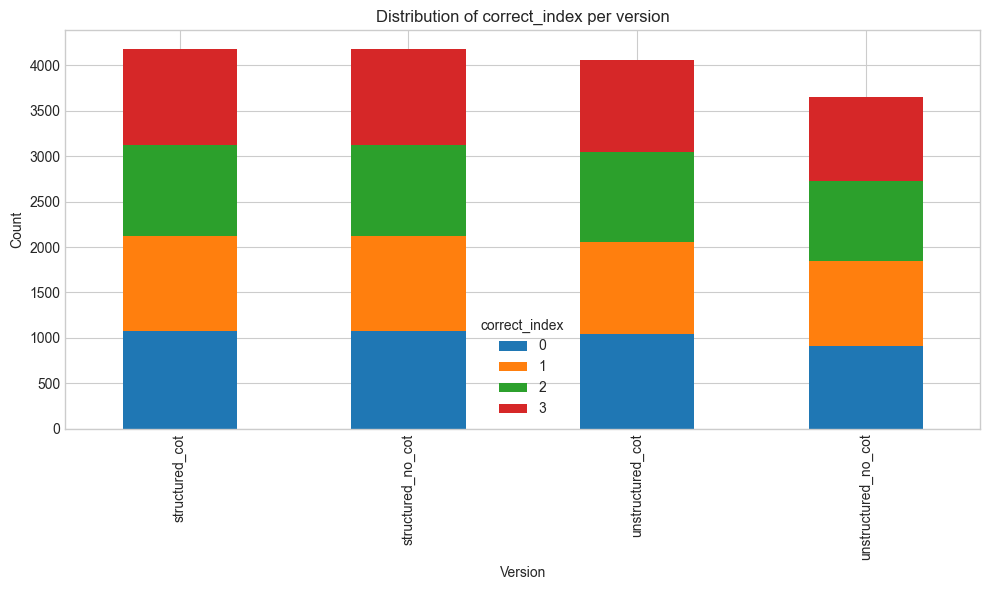

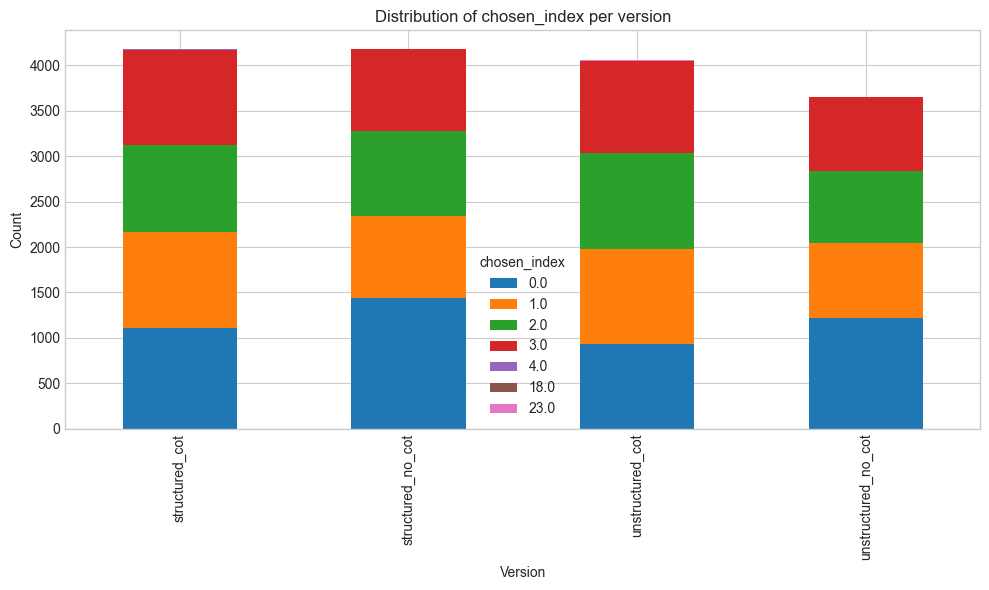

In [151]:
import matplotlib.pyplot as plt

# Plot value counts of correct_index per version
correct_counts = df.groupby('version')['correct_index'].value_counts().unstack(fill_value=0)
correct_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribution of correct_index per version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.legend(title='correct_index')
plt.tight_layout()
plt.show()

# Plot value counts of chosen_index per version
chosen_counts = df.groupby('version')['chosen_index'].value_counts().unstack(fill_value=0)
chosen_counts.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Distribution of chosen_index per version')
plt.xlabel('Version')
plt.ylabel('Count')
plt.legend(title='chosen_index')
plt.tight_layout()
plt.show()

In [154]:
import pandas as pd

df = pd.DataFrame(all_results)
df['correct'] = df['correct_index'] == df['chosen_index']
df.to_csv(f'mmlu_positional_bias_{llm.model_name.replace("/", "_")}.csv', index=False)
df.dropna(inplace=True)
df.head()

,version,latency,correct_index,chosen_index,question_hash,subject,model_name,correct
0,structured_no_cot,0.843754,3,3.0,7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df...,Physiology,openai/gpt-4.1-nano,True
1,structured_cot,1.116641,3,3.0,7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df...,Physiology,openai/gpt-4.1-nano,True
2,unstructured_cot,0.546126,3,3.0,7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df...,Physiology,openai/gpt-4.1-nano,True
3,unstructured_no_cot,1.261947,3,3.0,7640c9ba26fe25ced25556c6a48758f4c84aa6161bd7df...,Physiology,openai/gpt-4.1-nano,True
4,structured_no_cot,0.389927,2,0.0,c574b92a168f0f495c643aca04e97d9063e384c318d946...,Physiology,openai/gpt-4.1-nano,False


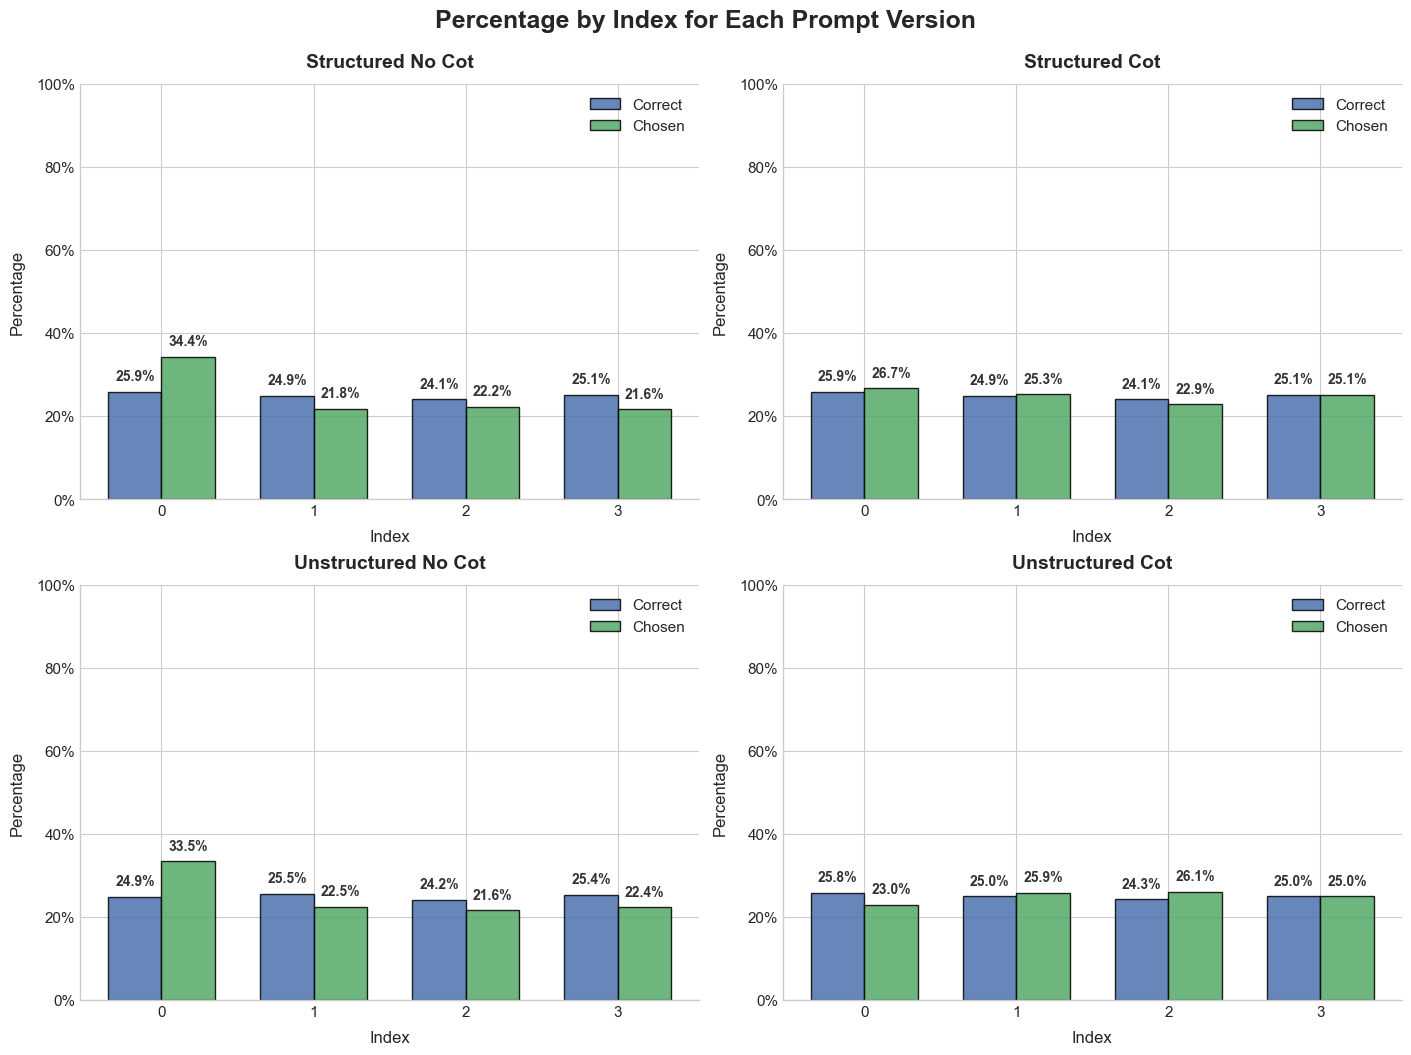

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

plt.style.use('seaborn-v0_8-whitegrid')  # Use a modern, clean style

def version_sort_key(v):
    v_lower = v.lower()
    if v_lower.startswith("structured"):
        row = 0
    elif v_lower.startswith("unstructured"):
        row = 1
    else:
        row = 2
    if "no_cot" in v_lower:
        col = 0
    elif "cot" in v_lower:
        col = 1
    else:
        col = 2
    return (row, col)

all_possible_indices = set(df['correct_index'])
indices = sorted(all_possible_indices)
versions = sorted(df['version'].unique(), key=version_sort_key)

summary = []
for version in versions:
    df_v = df[df['version'] == version]
    for idx in indices:
        pct_correct = (df_v['correct_index'] == idx).mean()
        pct_chosen = (df_v['chosen_index'] == idx).mean()
        summary.append({
            'version': version,
            'index': idx,
            'pct_correct': pct_correct,
            'pct_chosen': pct_chosen
        })

summary_df = pd.DataFrame(summary)

# Color palette for bars
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
x = np.arange(len(indices))

for i, version in enumerate(versions):
    row, col = version_sort_key(version)
    if row > 1 or col > 1:
        continue
    ax = axes[row, col]
    df_v = summary_df[summary_df['version'] == version]
    colors = bar_colors[:len(indices)]
    width = 0.35

    rects1 = ax.bar(x - width/2, df_v['pct_correct'], width, label='Correct', color='#4C72B0', edgecolor='black', alpha=0.85)
    rects2 = ax.bar(x + width/2, df_v['pct_chosen'], width, label='Chosen', color='#55A868', edgecolor='black', alpha=0.85)

    # Annotate bars with value
    for bar in rects1:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold', color='#333333')
    for bar in rects2:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold', color='#333333')

    ax.set_xlabel('Index', fontsize=12, labelpad=8)
    ax.set_ylabel('Percentage', fontsize=12, labelpad=8)
    ax.set_title(f'{version.replace("_", " ").title()}', fontsize=14, fontweight='bold', pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, fontsize=11)
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    ax.tick_params(axis='y', labelsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=11)

# Hide any unused subplots if there are less than 4 versions
for row in range(2):
    for col in range(2):
        idx = row * 2 + col
        if idx >= len(versions):
            fig.delaxes(axes[row, col])

fig.suptitle('Percentage by Index for Each Prompt Version', fontsize=18, fontweight='bold', y=1.04)
plt.savefig('mmlu_positional_bias_pct_by_index.png', dpi=300, bbox_inches='tight')
plt.show()


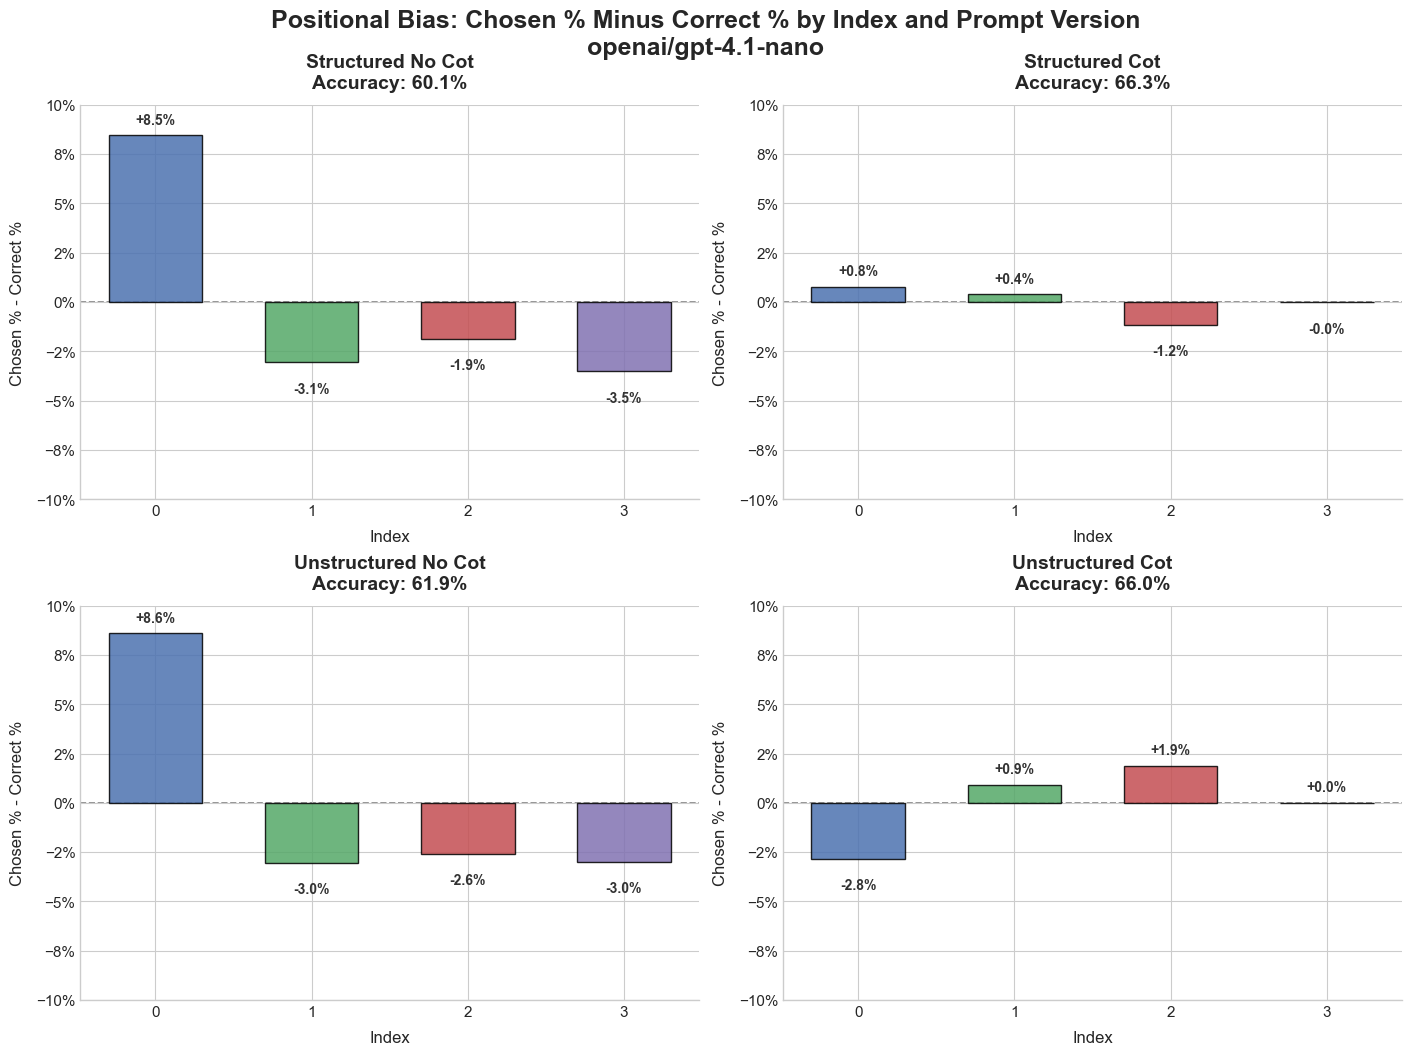

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

plt.style.use('seaborn-v0_8-whitegrid')  # Use a modern, clean style

all_possible_indices = set(df['correct_index'])
indices = sorted(all_possible_indices)

def version_sort_key(v):
    v_lower = v.lower()
    if v_lower.startswith("structured"):
        row = 0
    elif v_lower.startswith("unstructured"):
        row = 1
    else:
        row = 2
    if "no_cot" in v_lower:
        col = 0
    elif "cot" in v_lower:
        col = 1
    else:
        col = 2
    return (row, col)

versions = sorted(df['version'].unique(), key=version_sort_key)
accuracy_by_version = df.groupby('version')[['correct']].mean()['correct']

summary = []
for version in versions:
    df_v = df[df['version'] == version]
    for idx in indices:
        pct_correct = (df_v['correct_index'] == idx).mean()
        pct_chosen = (df_v['chosen_index'] == idx).mean()
        pct_diff = pct_chosen - pct_correct
        summary.append({
            'version': version,
            'index': idx,
            'pct_diff': pct_diff * 100
        })

summary_df = pd.DataFrame(summary)

# Color palette for bars
bar_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
x = np.arange(len(indices))

for version in versions:
    row, col = version_sort_key(version)
    if row > 1 or col > 1:
        continue
    ax = axes[row, col]
    df_v = summary_df[summary_df['version'] == version]
    # Use a color per bar if possible
    colors = bar_colors[:len(indices)]
    rects = ax.bar(x, df_v['pct_diff'], width=0.6, color=colors, edgecolor='black', alpha=0.85)
    ax.axhline(0, color='gray', linewidth=1.2, linestyle='--', zorder=0)

    # Annotate bars with value
    for bar in rects:
        height = bar.get_height()
        ax.annotate(f'{height:+.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6 if height >= 0 else -14),
                    textcoords="offset points",
                    ha='center', va='bottom' if height >= 0 else 'top',
                    fontsize=10, fontweight='bold', color='#333333')

    acc = accuracy_by_version[version]
    ax.set_xlabel('Index', fontsize=12, labelpad=8)
    ax.set_ylabel('Chosen % - Correct %', fontsize=12, labelpad=8)
    ax.set_title(f'{version.replace("_", " ").title()}\nAccuracy: {acc:.1%}', fontsize=14, fontweight='bold', pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels(indices, fontsize=11)
    ax.set_ylim(-10, 10)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.tick_params(axis='y', labelsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide any unused subplots if there are less than 4 versions
for row in range(2):
    for col in range(2):
        idx = row * 2 + col
        if idx >= len(versions):
            fig.delaxes(axes[row, col])

fig.suptitle(f'Positional Bias: Chosen % Minus Correct % by Index and Prompt Version\n{llm.model_name}', fontsize=18, fontweight='bold', y=1.04)
plt.savefig(f'mmlu_positional_bias_{llm.model_name.replace("/", "_")}.png', dpi=300, bbox_inches='tight')
plt.show()
